In [191]:
import numpy as np
import pandas as pd
import math
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

In [192]:
# Function to initialize ratings
def initialize_ratings(df_results, df_fixtures):
    ratings = {}

    # Iterate over teams in the results data
    teams = set(df_results['home_team']).union(set(df_results['away_team'])).union(set(df_fixtures['home_team'])).union(set(df_fixtures['away_team']))
    for team in teams:
        # Initialize ratings for each team
        ratings[team] = {
            'brH': 0.0,
            'brA': 0.0,
            'continuous_overunderperformances': 0
        }
    print('Teams:', teams, end='\n\n')
    return ratings

In [193]:
# Function to update ratings based on results data
def update_ratings_multiple_games(df_results, ratings):

    games_with_rating = []
    training_games = []

    # Iterate over each match in the results data
    for index, row in df_results.iterrows():

        if index > 2000:
            #add current game to training data
            training_games.append({
                "brH_x": ratings[row["home_team"]]["brH"],
                "brA_x": ratings[row["home_team"]]["brA"],
                "prH_x": calculate_provisional_ratings(ratings, row["home_team"])[0],
                "prA_x": calculate_provisional_ratings(ratings, row["home_team"])[1],
                "brH_y": ratings[row["away_team"]]["brH"],
                "brA_y": ratings[row["away_team"]]["brA"],
                "prH_y": calculate_provisional_ratings(ratings, row["away_team"])[0],
                "prA_y": calculate_provisional_ratings(ratings, row["away_team"])[1],
                "rating_difference": (calculate_provisional_ratings(ratings, row["home_team"])[0]) - (calculate_provisional_ratings(ratings, row["away_team"])[1]),
                "home_goals": row["home_goals"],
                "away_goals": row["away_goals"],
                "result": row["result"]
            })


        if np.isnan(ratings[row['home_team']]['brH']):
            print("error")
            break

        print("Game Nr:", index)

        time.sleep(0.001)

        ratings = update_ratings_single_game(row['home_team'], row['away_team'], row['home_goals'], row['away_goals'], ratings)

        games_with_rating.append({
            "team": row["home_team"],
            "home_rating": ratings[row["home_team"]]["brH"],
            "away_rating": ratings[row["home_team"]]["brA"],
            "continuous_overunderperformances": ratings[row["home_team"]]["continuous_overunderperformances"],
        })

        games_with_rating.append({
            "team": row["away_team"],
            "home_rating": ratings[row["away_team"]]["brH"],
            "away_rating": ratings[row["away_team"]]["brA"],
            "continuous_overunderperformances": ratings[row["away_team"]]["continuous_overunderperformances"],
        })

    return ratings, games_with_rating, training_games

In [194]:
# Function to update ratings based on results data
def update_ratings_single_game(home_team, away_team, home_goals, away_goals, ratings):

    #lambda: Determines to what extent the new match results influence the team ratings (could be improved to include temporal difference between matches)
    #learning_rate_lambda = 0.054
    learning_rate_lambda = 0.054

    #psi: diminish the impact each additional goal difference error has on team ratings
    diminishing_function_psi = lambda error: 3 * np.log10(1 + error)

    #gamma: determines to what extent performances at the home grounds influence away team ratings and vice versa
    learning_rate_gamma = 0.79

    #print(home_team, "-", away_team, home_goals, ":", away_goals)


    observed_goal_difference = home_goals - away_goals
    #print("Observed Goal Difference:", observed_goal_difference)

    #Calculate expected goals for home team
    #expected_goal_x = round((10 ** (abs(ratings[home_team]['brH']) / 3)) - 1,5)
    expected_goal_x_temp = abs(ratings[home_team]['brH']) / 3
    expected_goal_x = np.sign(ratings[home_team]['brH']) * (np.power(10, expected_goal_x_temp) - 1)
    #print("Expected Goals x:", expected_goal_x)

    # Calculate expected goals for away team
    #expected_goal_y = round((10 ** (abs(ratings[away_team]['brA']) / 3)) - 1,5)
    expected_goal_y_temp = abs(ratings[away_team]['brA']) / 3
    expected_goal_y = np.sign(ratings[away_team]['brA']) * (np.power(10, expected_goal_y_temp) - 1)
    #print("Expected Goals y:", expected_goal_y)

    # Calculate expected goal difference based on ratings
    expected_goal_difference = expected_goal_x - expected_goal_y
    #print("Expected Goal Difference:", expected_goal_difference)

    # Calculate the error between observed and expected goal difference
    error = abs(observed_goal_difference - expected_goal_difference)
    #print("error:", error)

    psi_temp = diminishing_function_psi(error)

    # Diminish the impact of the goal difference error for both teams x and y respectively
    if (expected_goal_difference < observed_goal_difference):
        diminishing_function_psi_x = psi_temp
        diminishing_function_psi_y = -psi_temp
    else:
        diminishing_function_psi_x = -psi_temp
        diminishing_function_psi_y = psi_temp
    #print("Diminishing Function psi x:", diminishing_function_psi_x)
    #print("Diminishing Function psi y:", diminishing_function_psi_y)

    # Update the home team x background ratings
    previous_home_rating_x = ratings[home_team]['brH']
    previous_away_rating_x = ratings[home_team]['brA']
    #print("Old brH x:", previous_home_rating_x)
    #print("Old brA x:", previous_away_rating_x)

    ratings[home_team]['brH'] = previous_home_rating_x + diminishing_function_psi_x * learning_rate_lambda
    ratings[home_team]['brA'] = previous_away_rating_x + (ratings[home_team]['brH'] - previous_home_rating_x) * learning_rate_gamma
    #print("New brH x:", ratings[home_team]['brH'])
    #print("New brA x:", ratings[home_team]['brA'])

    # Update the away team y background ratings
    previous_home_rating_y = ratings[away_team]['brH']
    previous_away_rating_y = ratings[away_team]['brA']
    #print("Old brH y:", previous_home_rating_y)
    #print("Old brA y:", previous_away_rating_y)

    ratings[away_team]['brA'] = previous_away_rating_y + diminishing_function_psi_y * learning_rate_lambda
    ratings[away_team]['brH'] = previous_home_rating_y + (ratings[away_team]['brA'] - previous_away_rating_y) * learning_rate_gamma
    #print("New brH y:", ratings[away_team]['brH'])
    #print("New brA y:", ratings[away_team]['brA'])

    #print("Old overunderperformance x:", ratings[home_team]['continuous_overunderperformances'])
    #print("Old overunderperformance y:", ratings[away_team]['continuous_overunderperformances'])

    # Update the continuous over/underperformances for the home team
    if (observed_goal_difference > expected_goal_difference):
        ratings[home_team]['continuous_overunderperformances'] = max(1, ratings[home_team]['continuous_overunderperformances'] + 1)
        ratings[away_team]['continuous_overunderperformances'] = min(-1, ratings[away_team]['continuous_overunderperformances'] - 1)
    elif (observed_goal_difference < expected_goal_difference):
        ratings[home_team]['continuous_overunderperformances'] = min(-1, ratings[home_team]['continuous_overunderperformances'] - 1)
        ratings[away_team]['continuous_overunderperformances'] = max(1, ratings[away_team]['continuous_overunderperformances'] + 1)
    else:
        ratings[home_team]['continuous_overunderperformances'] = 0
        ratings[away_team]['continuous_overunderperformances'] = 0

    #print("New overunderperformance x:", ratings[home_team]['continuous_overunderperformances'])
    #print("New overunderperformance y:", ratings[away_team]['continuous_overunderperformances'], end='\n\n')

    return ratings


In [195]:
def calculate_provisional_ratings(ratings, team):

    #phi: Represents the number of continuous performances, above or below expectations, which do not trigger the form factor
    form_threshold_phi = 1

    #mu: represents the rating difference used to establish provisional ratings from background ratings
    rating_impact_mu = 0.01

    #delta: the level by which rating impact μ diminishes with each additional continuous over/under-performance
    diminishing_factor_delta = 2.5

    brH = ratings[team]['brH']  # Background rating home
    brA = ratings[team]['brA']  # Background rating away
    prH = brH
    prA = brA

    if abs(ratings[team]['continuous_overunderperformances']) < 2:
        return prH, prA

    # Calculate performance factor for home team x
    a = abs(ratings[team]['continuous_overunderperformances']) - form_threshold_phi
    b = a ** diminishing_factor_delta
    form_factor_home = a / b

    # Calculate provisional rating of the team
    if (ratings[team]['continuous_overunderperformances'] > form_threshold_phi):
        prH = brH + rating_impact_mu * form_factor_home
        prA = brA + rating_impact_mu * form_factor_home
    if (ratings[team]['continuous_overunderperformances'] < -form_threshold_phi):
        prH = brH - rating_impact_mu * form_factor_home
        prA = brA - rating_impact_mu * form_factor_home

    return prH, prA

In [196]:
def calculate_probabilities(features):
    # Load the model and label encoder
    model = joblib.load('../Models/model.pkl')

    # Now you can predict probabilities for a new game:
    new_game_rating_difference = np.array([features])
    probabilities = model.predict_proba(new_game_rating_difference)
    return probabilities[0]

In [197]:
# Function to calculate the rating difference between two teams
def calculate_rating_difference(home_team, away_team, ratings):

    # Calculate home team rating
    home_rating_x = ratings[home_team]['brH']
    if (abs(ratings[home_team]['continuous_overunderperformances']) > 1):
        provisional_ratings_x = calculate_provisional_ratings(ratings, home_team)
        home_rating_x = provisional_ratings_x[0]

    # Calculate away team rating
    away_rating_y = ratings[away_team]['brA']
    if (abs(ratings[away_team]['continuous_overunderperformances']) > 1):
        provisional_ratings_y = calculate_provisional_ratings(ratings, away_team)
        away_rating_y = provisional_ratings_y[1]

    # Calculate rating difference
    rating_difference = home_rating_x - away_rating_y

    return rating_difference

In [198]:
def predict_outcomes(df_fixtures, ratings):
    all_rps = []
    for index, row in df_fixtures.iterrows():
        home_team = row['home_team']
        away_team = row['away_team']
        rating_difference = calculate_rating_difference(home_team, away_team, ratings)
        """
        prH_x = calculate_provisional_ratings(ratings, home_team)[0]
        prA_x = calculate_provisional_ratings(ratings, away_team)[1]
        prH_y = calculate_provisional_ratings(ratings, home_team)[0]
        prA_y = calculate_provisional_ratings(ratings, away_team)[1]
        """

        #features = [prH_x, prA_x, prH_y, prA_y]
        features = [rating_difference]

        away_win_prob, draw_prob, home_win_prob = calculate_probabilities(features)

        print(f"{home_team} - {away_team}: Outcome Predictions:")
        print(f"Home Win: {home_win_prob}")
        print(f"Draw: {draw_prob}")
        print(f"Away Win: {away_win_prob}")

        # Call Ranked Probability Score function
        probs = [home_win_prob, draw_prob, away_win_prob]
        if row["result"] == "H":
            outcome = [1, 0, 0]
        elif row["result"] == "D":
            outcome = [0, 1, 0]
        else:
            outcome = [0, 0, 1]

        rps_score = rps(probs, outcome)
        print("RPS Score:", rps_score, end='\n\n')
        all_rps.append(rps_score)

        ratings = update_ratings_single_game(home_team, away_team, row['home_goals'], row['away_goals'], ratings)

    print("Average RPS Score:", np.mean(all_rps))


In [199]:
def rps(probs, outcome):
    cum_probs = np.cumsum(probs)
    cum_outcomes = np.cumsum(outcome)

    sum_rps = 0
    for i in range(len(outcome)):
        sum_rps+= (cum_probs[i] - cum_outcomes[i])**2

    return sum_rps/(len(outcome)-1)

Teams: {'Derby County', 'Sunderland', 'Blackburn Rovers', 'Birmingham City', 'Leicester City', 'Brighton and Hove Albion', 'Liverpool', 'Bolton Wanderers', 'Aston Villa', 'Blackpool', 'Cardiff City', 'Burnley', 'Stoke City', 'Fulham', 'Manchester United', 'Queens Park Rangers', 'Reading', 'West Ham United', 'AFC Bournemouth', 'Charlton Athletic', 'Portsmouth', 'Norwich City', 'Huddersfield Town', 'Wigan Athletic', 'Tottenham Hotspur', 'Newcastle United', 'West Bromwich Albion', 'Hull City', 'Watford', 'Swansea City', 'Chelsea', 'Southampton', 'Middlesbrough', 'Everton', 'Sheffield United', 'Manchester City', 'Arsenal', 'Crystal Palace', 'Wolverhampton Wanderers'}

Game Nr: 0
Game Nr: 1
Game Nr: 2
Game Nr: 3
Game Nr: 4
Game Nr: 5
Game Nr: 6
Game Nr: 7
Game Nr: 8
Game Nr: 9
Game Nr: 10
Game Nr: 11
Game Nr: 12
Game Nr: 13
Game Nr: 14
Game Nr: 15
Game Nr: 16
Game Nr: 17
Game Nr: 18
Game Nr: 19
Game Nr: 20
Game Nr: 21
Game Nr: 22
Game Nr: 23
Game Nr: 24
Game Nr: 25
Game Nr: 26
Game Nr: 27
G

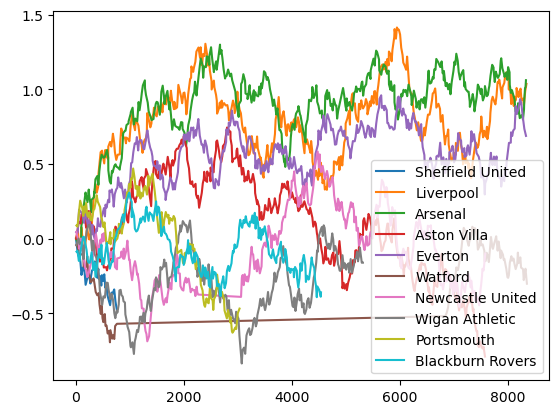

In [200]:

# Load the results data file for seasons 2006-07 to 2016-17
df_results = pd.read_csv('../data/results.csv')

# Load the fixtures data file for the season 2017-18
df_fixtures = pd.read_csv('../data/results201718.csv')

# Initialize ratings based on the results data
ratings = initialize_ratings(df_results, df_fixtures)

"""
ratings['Leicester City']['brH'] = 0.463014
ratings['Leicester City']['brA'] = 0.208624
ratings['Leicester City']['continuous_overunderperformances'] = 3

ratings['Stoke City']['brH'] = 0.537708
ratings['Stoke City']['brA'] = 0.037819
ratings['Stoke City']['continuous_overunderperformances'] = -1

ratings = update_ratings_single_game("Leicester City","Stoke City", 2, 0, ratings)
"""

# Update ratings based on the results data
ratings, games_with_ratings, training_games = update_ratings_multiple_games(df_results, ratings)



df_ratings = pd.DataFrame(games_with_ratings)
for team in df_ratings["team"].unique()[:10]:
    per_team = df_ratings.loc[df_ratings["team"] == team]
    plt.plot((per_team["home_rating"] + per_team["away_rating"]) / 2, label=team)
plt.legend()

df_train = pd.DataFrame(training_games)

df_train.to_csv("../data/train.csv", index=False)





In [201]:
# Predict the probabilities of home win, draw and away win for the fixtures data
predict_outcomes(df_fixtures, ratings)

"""
for team, team_ratings in ratings.items():
    print(f"Team: {team}")
    print(f"Background Rating Home: {team_ratings['brH']}")
    print(f"Background Rating Away: {team_ratings['brA']}")
    print(f"Continuous Over/Underperformances: {team_ratings['continuous_overunderperformances']}")
    print()
"""

"""
# Calculate the mean and standard deviation of the rating differences
rating_differences = calculate_rating_difference(df_results, ratings)
mean = np.mean(rating_differences)
std = np.std(rating_differences)
print("Mean:", mean)
print("Standard Deviation:", std, end='\n\n')
""";

Arsenal - Leicester City: Outcome Predictions:
Home Win: 0.6305257417341793
Draw: 0.2125991088346531
Away Win: 0.1568751494311676
RPS Score: 0.08056052001506477

Watford - Liverpool: Outcome Predictions:
Home Win: 0.16055077757528502
Draw: 0.26775386507757537
Away Win: 0.5716953573471396
RPS Score: 0.17630606689615116

Chelsea - Burnley: Outcome Predictions:
Home Win: 0.7710968967709683
Draw: 0.15113834096337125
Away Win: 0.07776476226566055
RPS Score: 0.7225541289643655

Crystal Palace - Huddersfield Town: Outcome Predictions:
Home Win: 0.40195136404363047
Draw: 0.27442090675228914
Away Win: 0.3236277292040804
RPS Score: 0.309522173879082

Everton - Stoke City: Outcome Predictions:
Home Win: 0.66520454144508
Draw: 0.19908412144145404
Away Win: 0.1357113371134659
RPS Score: 0.06525278304506198

Southampton - Swansea City: Outcome Predictions:
Home Win: 0.5114810060670598
Draw: 0.2509373820675807
Away Win: 0.23758161186535942
RPS Score: 0.15902892093195703

West Bromwich Albion - AFC Bo